In [4]:
import pandas as pd
import numpy as np
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.sentiment import SentimentIntensityAnalyzer

In [5]:

train_path = 'LIAR/train.tsv'
train_data = pd.read_csv(train_path,sep='\t', header=None, names=["id", "label", "statement", "subject(s)", "speaker","speaker's job title", "state info", "party affiliation", "barely true counts", "false counts","half true counts", "mostly true counts", "pants on fire counts", "context"])

train_data['label'] = train_data['label'].replace(['pants-fire', 'barely-true','false'], 0)
train_data['label'] = train_data['label'].replace(['half-true', 'mostly-true','true'], 1)

In [6]:
from nltk.sentiment import SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()
def analyze_sentiment(text):
    if isinstance(text, str) == False and text != 'NaN':
        return None
    words = word_tokenize(text)
   
    # filtered_words = [word for word in words if word.lower() not in stop_words]
    filtered_text = ' '.join(words)

    sentiment_scores = sid.polarity_scores(filtered_text) 
    return sentiment_scores['compound'] +1

In [7]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

stop_words = set(stopwords.words('english'))
train_data['sentiment'] = train_data['statement'].apply(analyze_sentiment)
train_features = train_data[['sentiment', 'statement']]
y_train = train_data['label']
train_features.head()

,sentiment,statement
0,1.2500,Says the Annies List political group supports ...
1,1.3612,When did the decline of coal start? It started...
2,1.3182,"Hillary Clinton agrees with John McCain ""by vo..."
3,1.7579,Health care reform legislation is likely to ma...
4,1.0000,The economic turnaround started at the end of ...


In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy import sparse

vectorizer = TfidfVectorizer()
X_train_statement = vectorizer.fit_transform(train_features['statement'])
X_train_sentiment = sparse.csr_matrix(train_features['sentiment'].values.reshape(-1, 1))
X_train_features = sparse.hstack((X_train_statement, X_train_sentiment))

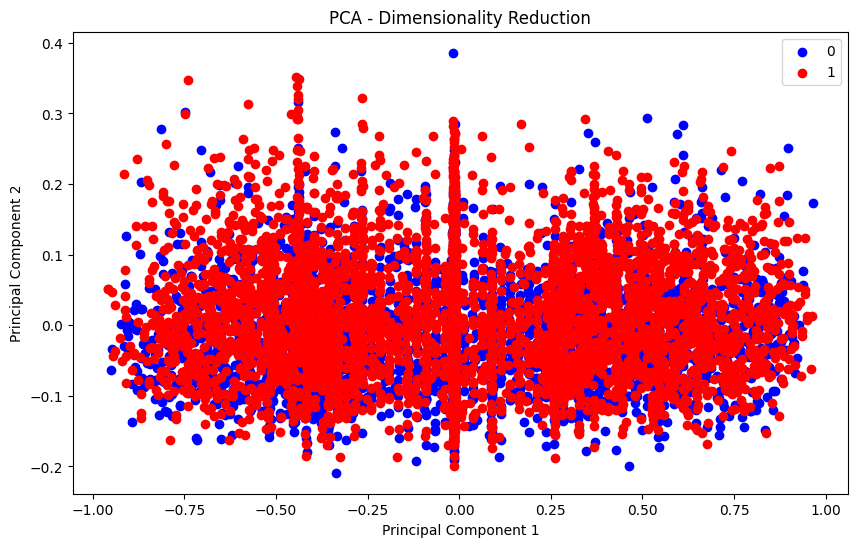

In [9]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np
pca = PCA(n_components=2) 
new_X = X_train_features.toarray()

X_reduced = pca.fit_transform(new_X)
df_reduced = pd.DataFrame(X_reduced, columns=['PC1', 'PC2'])
new_y = y_train.to_numpy()
df_reduced['category'] = new_y


plt.figure(figsize=(10, 6))
categories = np.unique(new_y)
colors = ['blue', 'red']

for category, color in zip(categories, colors):
    indices = df_reduced['category'] == category
    plt.scatter(df_reduced.loc[indices, 'PC1'], df_reduced.loc[indices, 'PC2'], c=color, label=category)

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.title('PCA - Dimensionality Reduction')
plt.show()

In [10]:
from sklearn.neighbors import KNeighborsClassifier
liar_knn_combined = KNeighborsClassifier(n_neighbors=5)
liar_knn_combined.fit(X_train_features, y_train)

liar_knn_statement = KNeighborsClassifier(n_neighbors=5)
liar_knn_statement.fit(X_train_statement, y_train)

liar_knn_sentiment = KNeighborsClassifier(n_neighbors=5)
liar_knn_sentiment.fit(X_train_sentiment, y_train)

KNeighborsClassifier()

In [11]:
valid_path = 'LIAR/valid.tsv'
valid_data = pd.read_csv(valid_path,sep='\t', header=None, names=["id", "label", "statement", "subject(s)", "speaker","speaker's job title", "state info", "party affiliation", "barely true counts", "false counts","half true counts", "mostly true counts", "pants on fire counts", "context"])

valid_data['label'] = valid_data['label'].replace(['pants-fire', 'barely-true','false'], 0)
valid_data['label'] = valid_data['label'].replace(['half-true', 'mostly-true','true'], 1)

valid_data['sentiment'] = valid_data['statement'].apply(analyze_sentiment)
valid_features = valid_data[['sentiment', 'statement']]
y_valid = valid_data['label']

In [12]:
X_valid_statement = vectorizer.transform(valid_data['statement'])
X_valid_sentiment = sparse.csr_matrix(valid_data['sentiment'].values.reshape(-1, 1))
X_valid_features = sparse.hstack((X_valid_statement, X_valid_sentiment))

In [13]:
from sklearn.metrics import accuracy_score
y_combined_pred = liar_knn_combined.predict(X_valid_features)
combined_accuracy = accuracy_score(valid_data['label'], y_combined_pred)
print("Accuracy for combined features:", combined_accuracy)

y_statement_pred = liar_knn_statement.predict(X_valid_statement)
statement_accuracy = accuracy_score(valid_data['label'], y_statement_pred)
print("Accuracy for statement features:", statement_accuracy)

y_sentiment_pred = liar_knn_sentiment.predict(X_valid_sentiment)
sentiment_accuracy = accuracy_score(valid_data['label'], y_sentiment_pred)
print("Accuracy for sentiment features:", sentiment_accuracy)

Accuracy for combined features: 0.5716510903426791
Accuracy for statement features: 0.5708722741433022
Accuracy for sentiment features: 0.5062305295950156


In [14]:
test_path = 'LIAR/test.tsv'

test_data = pd.read_csv(test_path,sep='\t', header=None, names=["id", "label", "statement", "subject(s)", "speaker","speaker's job title", "state info", "party affiliation", "barely true counts", "false counts","half true counts", "mostly true counts", "pants on fire counts", "context"])

test_data['label'] = test_data['label'].replace(['pants-fire', 'barely-true','false'], 0)
test_data['label'] = test_data['label'].replace(['half-true', 'mostly-true','true'], 1)
test_data['sentiment'] = test_data['statement'].apply(analyze_sentiment)
test_features = test_data[['sentiment', 'statement']]
y_test = test_data['label']

In [15]:
X_test_statement = vectorizer.transform(test_data['statement'])
X_test_sentiment = sparse.csr_matrix(test_data['sentiment'].values.reshape(-1, 1))
X_test_features = sparse.hstack((X_test_statement, X_test_sentiment))

In [16]:
y_combined_pred_test = liar_knn_combined.predict(X_test_features)
combined_accuracy_test = accuracy_score(test_data['label'], y_combined_pred_test)
print("Accuracy for combined features:", combined_accuracy_test)

y_statement_pred_test = liar_knn_statement.predict(X_test_statement)
statement_accuracy_test = accuracy_score(test_data['label'], y_statement_pred_test)
print("Accuracy for statement features:", statement_accuracy_test)

y_sentiment_pred_test = liar_knn_sentiment.predict(X_test_sentiment)
sentiment_accuracy_test = accuracy_score(test_data['label'], y_sentiment_pred_test)
print("Accuracy for sentiment features:", sentiment_accuracy_test)


Accuracy for combined features: 0.6045777426992897
Accuracy for statement features: 0.585635359116022
Accuracy for sentiment features: 0.5343330702446725


In [17]:
fakeddit_train_path1 = 'Fakeddit/train1.tsv'
fakeddit_train_path2 = 'Fakeddit/train2.tsv'
fakeddit_train_path3 = 'Fakeddit/train3.tsv'

fakeddit_train_data1 = pd.read_csv(fakeddit_train_path1, sep='\t')
fakeddit_train_data2 = pd.read_csv(fakeddit_train_path2, sep='\t')
fakeddit_train_data3 = pd.read_csv(fakeddit_train_path3, sep='\t')
fakeddit_train_data = pd.concat([fakeddit_train_data1, fakeddit_train_data2, fakeddit_train_data3], ignore_index=True)
fakeddit_train_data = fakeddit_train_data[fakeddit_train_data['clean_title'].notna()]
fakeddit_train_data['sentiment'] = fakeddit_train_data['clean_title'].apply(analyze_sentiment) 


In [18]:
vectorizer_fakeddit = TfidfVectorizer()
X_train_statement_fakeddit = vectorizer_fakeddit.fit_transform(fakeddit_train_data['clean_title'])
X_train_sentiment_fakeddit = sparse.csr_matrix(fakeddit_train_data['sentiment'].values.reshape(-1, 1))
X_train_features_fakeddit = sparse.hstack((X_train_statement_fakeddit, X_train_sentiment_fakeddit))

In [19]:
fakeddit_knn_combined = KNeighborsClassifier(n_neighbors=5)
fakeddit_knn_combined.fit(X_train_features_fakeddit, fakeddit_train_data['2_way_label'])

fakeddit_knn_title = KNeighborsClassifier(n_neighbors=5)
fakeddit_knn_title.fit(X_train_statement_fakeddit, fakeddit_train_data['2_way_label'])

fakeddit_knn_sentiment = KNeighborsClassifier(n_neighbors=5)
fakeddit_knn_sentiment.fit(X_train_sentiment_fakeddit, fakeddit_train_data['2_way_label'])

KNeighborsClassifier()

In [20]:
fakeddit_valid_path = 'Fakeddit/all_validate.tsv'
fakeddit_valid_data = pd.read_csv(fakeddit_valid_path, sep='\t')
fakeddit_valid_data = fakeddit_valid_data[fakeddit_valid_data['clean_title'].notna()]
fakeddit_valid_data['sentiment'] = fakeddit_valid_data['clean_title'].apply(analyze_sentiment)

In [21]:
X_valid_statement_fakeddit = vectorizer_fakeddit.transform(fakeddit_valid_data['clean_title'])
X_valid_sentiment_fakeddit = sparse.csr_matrix(fakeddit_valid_data['sentiment'].values.reshape(-1, 1))
X_valid_features_fakeddit = sparse.hstack((X_valid_statement_fakeddit, X_valid_sentiment_fakeddit))

In [22]:
y_combined_pred_fakeddit = fakeddit_knn_combined.predict(X_valid_features_fakeddit)
combined_accuracy_fakeddit = accuracy_score(fakeddit_valid_data['2_way_label'], y_combined_pred_fakeddit)
print("Accuracy for combined features:", combined_accuracy_fakeddit)

y_statement_pred_fakeddit = fakeddit_knn_title.predict(X_valid_statement_fakeddit)
statement_accuracy_fakeddit = accuracy_score(fakeddit_valid_data['2_way_label'], y_statement_pred_fakeddit)
print("Accuracy for statement features:", statement_accuracy_fakeddit)

y_sentiment_pred_fakeddit = fakeddit_knn_sentiment.predict(X_valid_sentiment_fakeddit)
sentiment_accuracy_fakeddit = accuracy_score(fakeddit_valid_data['2_way_label'], y_sentiment_pred_fakeddit)
print("Accuracy for sentiment features:", sentiment_accuracy_fakeddit)

Accuracy for combined features: 0.6153709662155767
Accuracy for statement features: 0.5937588719598751
Accuracy for sentiment features: 0.48811157376738906


In [ ]:
fakeddit_full_data = pd.concat([fakeddit_train_data, fakeddit_valid_data], ignore_index=True)
full_vectorizer = TfidfVectorizer()
X_full_statement = full_vectorizer.fit_transform(fakeddit_full_data['clean_title'])
X_full_sentiment = sparse.csr_matrix(fakeddit_full_data['sentiment'].values.reshape(-1, 1))
X_full_features = sparse.hstack((X_full_statement, X_full_sentiment))